# State Reconstruction after two-qubit channel application

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator


import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

tf.debugging.set_log_device_placement(False)

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation

In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [6]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Useful Functions

In [7]:
#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [8]:
#function which returns density matrix from bloch components
def rho_from_coeffs(coeffs):
    rho = 0.25 * np.sum([c * p for c,p in zip(coeffs, pauli_basis2q)], axis=0)
    return rho

In [9]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]


def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   return fidelity 

In [10]:
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = 1 - fidelity
   infidelity = tf.cast(infidelity, dtype = tf.float32)
   return infidelity 

## Noise Model 

In [11]:
#SINGLE ELEMENT OF THE OPERATOR-SUM REPRESENTATION

def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [12]:
#CORRELATED TWO-QUBIT AMPLITUDE DAMPING CHANNEL

def corr_twoq_ad(num_qubits, rho, eta, mu):
    
    E_0 = np.array([[1, 0], [0, np.sqrt(eta)]])
    E_1 = np.array([[0, np.sqrt(1 - eta)], [0, 0]])
    
    A_0 = np.kron(E_0, E_0)
    A_1 = np.kron(E_0, E_1)
    A_2 = np.kron(E_1, E_0)
    A_3 = np.kron(E_1, E_1)


    B_0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, np.sqrt(eta)]])
    B_1 = np.array([[0, 0, 0, np.sqrt(1 - eta)], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

    N_0 = sum_element(rho, A_0) + sum_element(rho, A_1) + sum_element(rho, A_2) + sum_element(rho, A_3)
    N_1 = sum_element(rho, B_0) + sum_element(rho, B_1)

    noisy_rho = (1 - mu) * N_0 + mu * N_1
    return noisy_rho

## Training the Algorithm

In [13]:
data = generate_Haar_data(2, 10000) 
density_matrix_noise_free = [*map(get_density_matrix, data)] 
bloch_vectors_noise_free = [*map(bloch_coeffs, density_matrix_noise_free)]

In [14]:
#APPLY ERROR 
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = corr_twoq_ad(2, density_matrix_noise_free[i], 0.1, 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

#PRINT THE TYPE OF THE SINGLE DENSITY MATRIX IN THE LISTS OF THE DENSITY MATRICES WITH NOISE
print("Density matrix with noise type:", density_matrix_with_noise[0].dtype)

#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(bloch_coeffs, density_matrix_with_noise)]
print("Bloch vector with noise type:", bloch_vectors_with_noise[0].dtype)

Density matrix with noise type: complex128
Bloch vector with noise type: complex128


## <font color='red'>MSE</font>

In [15]:
x_train_list = bloch_vectors_with_noise[:700]
y_train_list = bloch_vectors_noise_free[:700]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = bloch_vectors_with_noise[800:900]
y_val_list = bloch_vectors_noise_free[800:900]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = bloch_vectors_with_noise[900:1000]
y_test_list = bloch_vectors_noise_free[900:1000]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [16]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  #tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [17]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [18]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=900)

Epoch 1/900
7/7 [==============================] - 1s 36ms/step - loss: 0.2004 - val_loss: 0.1945
Epoch 2/900
7/7 [==============================] - 0s 8ms/step - loss: 0.1941 - val_loss: 0.1899
Epoch 3/900
7/7 [==============================] - 0s 9ms/step - loss: 0.1895 - val_loss: 0.1866
Epoch 4/900
7/7 [==============================] - 0s 8ms/step - loss: 0.1858 - val_loss: 0.1837
Epoch 5/900
7/7 [==============================] - 0s 10ms/step - loss: 0.1827 - val_loss: 0.1809
Epoch 6/900
7/7 [==============================] - 0s 9ms/step - loss: 0.1795 - val_loss: 0.1775
Epoch 7/900
7/7 [==============================] - 0s 9ms/step - loss: 0.1763 - val_loss: 0.1742
Epoch 8/900
7/7 [==============================] - 0s 8ms/step - loss: 0.1731 - val_loss: 0.1711
Epoch 9/900
7/7 [==============================] - 0s 10ms/step - loss: 0.1700 - val_loss: 0.1678
Epoch 10/900
7/7 [==============================] - 0s 9ms/step - loss: 0.1669 - val_loss: 0.1648
Epoch 11/900
7/7 [========

7/7 [==============================] - 0s 8ms/step - loss: 0.0484 - val_loss: 0.0476
Epoch 85/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0477 - val_loss: 0.0468
Epoch 86/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0470 - val_loss: 0.0463
Epoch 87/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0463 - val_loss: 0.0458
Epoch 88/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0456 - val_loss: 0.0451
Epoch 89/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0448 - val_loss: 0.0443
Epoch 90/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0442 - val_loss: 0.0438
Epoch 91/900
7/7 [==============================] - 0s 9ms/step - loss: 0.0435 - val_loss: 0.0431
Epoch 92/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0428 - val_loss: 0.0424
Epoch 93/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0421 - val_loss: 0.0420
Epoch 94/900
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0122
Epoch 168/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0120
Epoch 169/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0103 - val_loss: 0.0119
Epoch 170/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0118
Epoch 171/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0118
Epoch 172/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0116
Epoch 173/900
7/7 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0119
Epoch 174/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0115
Epoch 175/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0116
Epoch 176/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0098 - val_loss: 0.0115
Epoch 177/900
7/7 [=====

Epoch 250/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0090
Epoch 251/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0090
Epoch 252/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0090
Epoch 253/900
7/7 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0089
Epoch 254/900
7/7 [==============================] - 0s 15ms/step - loss: 0.0070 - val_loss: 0.0088
Epoch 255/900
7/7 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0089
Epoch 256/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0069 - val_loss: 0.0088
Epoch 257/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0069 - val_loss: 0.0088
Epoch 258/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0087
Epoch 259/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0069 - val_loss: 0.0087
Epoch 260

7/7 [==============================] - 0s 9ms/step - loss: 0.0048 - val_loss: 0.0069
Epoch 333/900
7/7 [==============================] - 0s 14ms/step - loss: 0.0049 - val_loss: 0.0068
Epoch 334/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0067
Epoch 335/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0066
Epoch 336/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0067
Epoch 337/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 338/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0067
Epoch 339/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 340/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0064
Epoch 341/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 342/900
7/7 [====

Epoch 415/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0052
Epoch 416/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 417/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 418/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 419/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 420/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 421/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 422/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 423/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 424/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0051
Epoch 425/

7/7 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 498/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 499/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 500/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 501/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 502/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 503/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 504/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 505/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 506/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 507/900
7/7 [=====

Epoch 580/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 581/900
7/7 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 582/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 583/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 584/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 585/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 586/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 587/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 588/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 589/900
7/7 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 590/

7/7 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 663/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 664/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 665/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 666/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 667/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 668/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 669/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 670/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 671/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 672/900
7/7 [=====

7/7 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 745/900
7/7 [==============================] - 0s 8ms/step - loss: 9.7704e-04 - val_loss: 0.0020
Epoch 746/900
7/7 [==============================] - 0s 8ms/step - loss: 9.7920e-04 - val_loss: 0.0020
Epoch 747/900
7/7 [==============================] - 0s 8ms/step - loss: 9.7873e-04 - val_loss: 0.0020
Epoch 748/900
7/7 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 749/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 750/900
7/7 [==============================] - 0s 8ms/step - loss: 9.7588e-04 - val_loss: 0.0019
Epoch 751/900
7/7 [==============================] - 0s 7ms/step - loss: 9.6266e-04 - val_loss: 0.0020
Epoch 752/900
7/7 [==============================] - 0s 8ms/step - loss: 9.6353e-04 - val_loss: 0.0019
Epoch 753/900
7/7 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0020


Epoch 824/900
7/7 [==============================] - 0s 7ms/step - loss: 7.7722e-04 - val_loss: 0.0016
Epoch 825/900
7/7 [==============================] - 0s 8ms/step - loss: 7.8609e-04 - val_loss: 0.0016
Epoch 826/900
7/7 [==============================] - 0s 7ms/step - loss: 7.7092e-04 - val_loss: 0.0016
Epoch 827/900
7/7 [==============================] - 0s 8ms/step - loss: 7.7995e-04 - val_loss: 0.0016
Epoch 828/900
7/7 [==============================] - 0s 7ms/step - loss: 7.8020e-04 - val_loss: 0.0016
Epoch 829/900
7/7 [==============================] - 0s 8ms/step - loss: 8.1923e-04 - val_loss: 0.0016
Epoch 830/900
7/7 [==============================] - 0s 8ms/step - loss: 7.9350e-04 - val_loss: 0.0016
Epoch 831/900
7/7 [==============================] - 0s 8ms/step - loss: 7.7943e-04 - val_loss: 0.0016
Epoch 832/900
7/7 [==============================] - 0s 8ms/step - loss: 7.6770e-04 - val_loss: 0.0016
Epoch 833/900
7/7 [==============================] - 0s 7ms/step - loss: 

In [19]:
score = model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 0.0016 - 114ms/epoch - 29ms/step


In [20]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_mse = tf.math.reduce_mean(fid)
print(fid_mse)

tf.Tensor((0.99049157+2.1333944e-05j), shape=(), dtype=complex64)


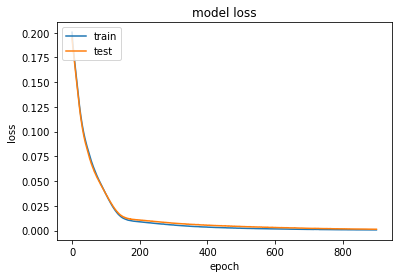

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='green'>Training the Algorithm (INF)</font>

In [22]:
x_train_list = bloch_vectors_with_noise[:5000]
y_train_list = bloch_vectors_noise_free[:5000]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = bloch_vectors_with_noise[9000:9500]
y_val_list = bloch_vectors_noise_free[9000:9500]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = bloch_vectors_with_noise[9500:]
y_test_list = bloch_vectors_noise_free[9500:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [23]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [24]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [25]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=1000, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 3s 121ms/step - loss: 0.7403 - val_loss: 0.7376
Epoch 2/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.7220 - val_loss: 0.7219
Epoch 3/1000
5/5 [==============================] - 0s 51ms/step - loss: 0.7039 - val_loss: 0.7053
Epoch 4/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.6874 - val_loss: 0.6909
Epoch 5/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.6729 - val_loss: 0.6756
Epoch 6/1000
5/5 [==============================] - 0s 44ms/step - loss: 0.6558 - val_loss: 0.6567
Epoch 7/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.6341 - val_loss: 0.6320
Epoch 8/1000
5/5 [==============================] - 0s 44ms/step - loss: 0.6057 - val_loss: 0.5987
Epoch 9/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.5700 - val_loss: 0.5650
Epoch 10/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.5512 - val_loss: 0.5655
Epoch 11

5/5 [==============================] - 0s 47ms/step - loss: 0.3888 - val_loss: 0.3873
Epoch 84/1000
5/5 [==============================] - 0s 40ms/step - loss: 0.3850 - val_loss: 0.3860
Epoch 85/1000
5/5 [==============================] - 0s 42ms/step - loss: 0.3854 - val_loss: 0.3866
Epoch 86/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.3870 - val_loss: 0.3864
Epoch 87/1000
5/5 [==============================] - 0s 41ms/step - loss: 0.3865 - val_loss: 0.3852
Epoch 88/1000
5/5 [==============================] - 0s 41ms/step - loss: 0.3851 - val_loss: 0.3834
Epoch 89/1000
5/5 [==============================] - 0s 41ms/step - loss: 0.3975 - val_loss: 0.4195
Epoch 90/1000
5/5 [==============================] - 0s 40ms/step - loss: 0.4280 - val_loss: 0.4449
Epoch 91/1000
5/5 [==============================] - 0s 41ms/step - loss: 0.4477 - val_loss: 0.4595
Epoch 92/1000
5/5 [==============================] - 0s 40ms/step - loss: 0.4581 - val_loss: 0.4655
Epoch 93/1000


5/5 [==============================] - 0s 40ms/step - loss: 0.4130 - val_loss: 0.4128
Epoch 165/1000
5/5 [==============================] - 0s 40ms/step - loss: 0.4119 - val_loss: 0.4091
Epoch 166/1000
5/5 [==============================] - 0s 40ms/step - loss: 0.4079 - val_loss: 0.4034
Epoch 167/1000
5/5 [==============================] - 0s 39ms/step - loss: 0.4025 - val_loss: 0.3976
Epoch 168/1000
5/5 [==============================] - 0s 39ms/step - loss: 0.3972 - val_loss: 0.3908
Epoch 169/1000
5/5 [==============================] - 0s 42ms/step - loss: 0.3899 - val_loss: 0.3818
Epoch 170/1000
5/5 [==============================] - 0s 41ms/step - loss: 0.3809 - val_loss: 0.3734
Epoch 171/1000
5/5 [==============================] - 0s 39ms/step - loss: 0.3747 - val_loss: 0.3693
Epoch 172/1000
5/5 [==============================] - 0s 39ms/step - loss: 0.3705 - val_loss: 0.3650
Epoch 173/1000
5/5 [==============================] - 0s 40ms/step - loss: 0.3646 - val_loss: 0.3571
Epoch

5/5 [==============================] - 0s 44ms/step - loss: 0.3002 - val_loss: 0.2955
Epoch 246/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.3020 - val_loss: 0.3016
Epoch 247/1000
5/5 [==============================] - 0s 43ms/step - loss: 0.3112 - val_loss: 0.3122
Epoch 248/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.3195 - val_loss: 0.3159
Epoch 249/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.3219 - val_loss: 0.3181
Epoch 250/1000
5/5 [==============================] - 0s 44ms/step - loss: 0.3261 - val_loss: 0.3247
Epoch 251/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.3331 - val_loss: 0.3291
Epoch 252/1000
5/5 [==============================] - 0s 48ms/step - loss: 0.3515 - val_loss: 0.3660
Epoch 253/1000
5/5 [==============================] - 0s 48ms/step - loss: 0.3828 - val_loss: 0.3873
Epoch 254/1000
5/5 [==============================] - 0s 42ms/step - loss: 0.3984 - val_loss: 0.3946
Epoch

5/5 [==============================] - 0s 46ms/step - loss: 0.2628 - val_loss: 0.2661
Epoch 327/1000
5/5 [==============================] - 0s 43ms/step - loss: 0.2733 - val_loss: 0.2836
Epoch 328/1000
5/5 [==============================] - 0s 48ms/step - loss: 0.2872 - val_loss: 0.2935
Epoch 329/1000
5/5 [==============================] - 0s 48ms/step - loss: 0.2934 - val_loss: 0.2962
Epoch 330/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.2960 - val_loss: 0.2975
Epoch 331/1000
5/5 [==============================] - 0s 49ms/step - loss: 0.2967 - val_loss: 0.3006
Epoch 332/1000
5/5 [==============================] - 0s 49ms/step - loss: 0.3028 - val_loss: 0.3068
Epoch 333/1000
5/5 [==============================] - 0s 44ms/step - loss: 0.3053 - val_loss: 0.2987
Epoch 334/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.2936 - val_loss: 0.2835
Epoch 335/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.2814 - val_loss: 0.2704
Epoch

5/5 [==============================] - 0s 45ms/step - loss: 0.3795 - val_loss: 0.3702
Epoch 408/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.3792 - val_loss: 0.3704
Epoch 409/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.3845 - val_loss: 0.3780
Epoch 410/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.3931 - val_loss: 0.3916
Epoch 411/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.4045 - val_loss: 0.3988
Epoch 412/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.4076 - val_loss: 0.3978
Epoch 413/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.4041 - val_loss: 0.3917
Epoch 414/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.3964 - val_loss: 0.3822
Epoch 415/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.3857 - val_loss: 0.3703
Epoch 416/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.3728 - val_loss: 0.3565
Epoch

5/5 [==============================] - 0s 51ms/step - loss: 0.3694 - val_loss: 0.4060
Epoch 489/1000
5/5 [==============================] - 0s 44ms/step - loss: 0.4167 - val_loss: 0.4323
Epoch 490/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.4328 - val_loss: 0.4385
Epoch 491/1000
5/5 [==============================] - 0s 51ms/step - loss: 0.4378 - val_loss: 0.4394
Epoch 492/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.4347 - val_loss: 0.4327
Epoch 493/1000
5/5 [==============================] - 0s 50ms/step - loss: 0.4278 - val_loss: 0.4247
Epoch 494/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.4197 - val_loss: 0.4157
Epoch 495/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.4105 - val_loss: 0.4057
Epoch 496/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.4007 - val_loss: 0.3956
Epoch 497/1000
5/5 [==============================] - 0s 49ms/step - loss: 0.3901 - val_loss: 0.3843
Epoch

5/5 [==============================] - 0s 48ms/step - loss: 0.2628 - val_loss: 0.2595
Epoch 570/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.2590 - val_loss: 0.2543
Epoch 571/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.2587 - val_loss: 0.2621
Epoch 572/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.2670 - val_loss: 0.2698
Epoch 573/1000
5/5 [==============================] - 0s 50ms/step - loss: 0.2736 - val_loss: 0.2745
Epoch 574/1000
5/5 [==============================] - 0s 49ms/step - loss: 0.2742 - val_loss: 0.2695
Epoch 575/1000
5/5 [==============================] - 0s 49ms/step - loss: 0.2709 - val_loss: 0.2691
Epoch 576/1000
5/5 [==============================] - 0s 50ms/step - loss: 0.2716 - val_loss: 0.2707
Epoch 577/1000
5/5 [==============================] - 0s 52ms/step - loss: 0.2742 - val_loss: 0.2734
Epoch 578/1000
5/5 [==============================] - 0s 50ms/step - loss: 0.2745 - val_loss: 0.2703
Epoch

5/5 [==============================] - 0s 48ms/step - loss: 0.2508 - val_loss: 0.2484
Epoch 651/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.2455 - val_loss: 0.2503
Epoch 652/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.2493 - val_loss: 0.2561
Epoch 653/1000
5/5 [==============================] - 0s 50ms/step - loss: 0.2544 - val_loss: 0.2645
Epoch 654/1000
5/5 [==============================] - 0s 49ms/step - loss: 0.2613 - val_loss: 0.2698
Epoch 655/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.2641 - val_loss: 0.2698
Epoch 656/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.2602 - val_loss: 0.2592
Epoch 657/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.2500 - val_loss: 0.2489
Epoch 658/1000
5/5 [==============================] - 0s 48ms/step - loss: 0.2413 - val_loss: 0.2404
Epoch 659/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.2340 - val_loss: 0.2328
Epoch

5/5 [==============================] - 0s 46ms/step - loss: 0.2029 - val_loss: 0.2059
Epoch 732/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.2023 - val_loss: 0.2053
Epoch 733/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.2014 - val_loss: 0.2026
Epoch 734/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.1994 - val_loss: 0.2025
Epoch 735/1000
5/5 [==============================] - 0s 48ms/step - loss: 0.2094 - val_loss: 0.2189
Epoch 736/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.2271 - val_loss: 0.2321
Epoch 737/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.2303 - val_loss: 0.2240
Epoch 738/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.2244 - val_loss: 0.2239
Epoch 739/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.2239 - val_loss: 0.2245
Epoch 740/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.2231 - val_loss: 0.2233
Epoch

5/5 [==============================] - 0s 46ms/step - loss: 0.1790 - val_loss: 0.1794
Epoch 813/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.1757 - val_loss: 0.1756
Epoch 814/1000
5/5 [==============================] - 0s 48ms/step - loss: 0.1734 - val_loss: 0.1745
Epoch 815/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.1737 - val_loss: 0.1771
Epoch 816/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.1774 - val_loss: 0.1796
Epoch 817/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.1772 - val_loss: 0.1785
Epoch 818/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.1756 - val_loss: 0.1773
Epoch 819/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.1736 - val_loss: 0.1770
Epoch 820/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.1737 - val_loss: 0.1780
Epoch 821/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.1772 - val_loss: 0.1886
Epoch

5/5 [==============================] - 0s 46ms/step - loss: 0.1967 - val_loss: 0.1989
Epoch 894/1000
5/5 [==============================] - 0s 48ms/step - loss: 0.1964 - val_loss: 0.1987
Epoch 895/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.1961 - val_loss: 0.1980
Epoch 896/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.1950 - val_loss: 0.1969
Epoch 897/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.1938 - val_loss: 0.1958
Epoch 898/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.1915 - val_loss: 0.1934
Epoch 899/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.1903 - val_loss: 0.1930
Epoch 900/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.1895 - val_loss: 0.1913
Epoch 901/1000
5/5 [==============================] - 0s 45ms/step - loss: 0.1871 - val_loss: 0.1886
Epoch 902/1000
5/5 [==============================] - 0s 48ms/step - loss: 0.1857 - val_loss: 0.1877
Epoch

5/5 [==============================] - 0s 48ms/step - loss: 0.3652 - val_loss: 0.3452
Epoch 975/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.3399 - val_loss: 0.3232
Epoch 976/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.3186 - val_loss: 0.3044
Epoch 977/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.3001 - val_loss: 0.2879
Epoch 978/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.2842 - val_loss: 0.2725
Epoch 979/1000
5/5 [==============================] - 0s 46ms/step - loss: 0.2660 - val_loss: 0.2534
Epoch 980/1000
5/5 [==============================] - 0s 44ms/step - loss: 0.2476 - val_loss: 0.2372
Epoch 981/1000
5/5 [==============================] - 0s 48ms/step - loss: 0.2310 - val_loss: 0.2222
Epoch 982/1000
5/5 [==============================] - 0s 49ms/step - loss: 0.2162 - val_loss: 0.2109
Epoch 983/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.2044 - val_loss: 0.2002
Epoch

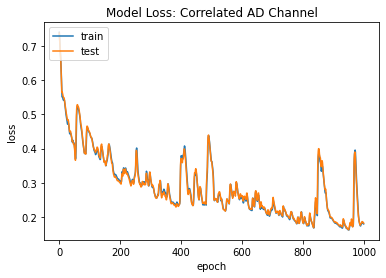

In [26]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Correlated AD Channel')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(0,30)
plt.show()

In [27]:
score = model.evaluate(x_test,  y_test, verbose=2)

16/16 - 0s - loss: 0.1778 - 74ms/epoch - 5ms/step


In [28]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_inf = tf.math.reduce_mean(fid)
print(fid_inf)

tf.Tensor((0.8222169+7.979674e-06j), shape=(), dtype=complex64)
